# AI in Medicine I - Practical 2: Brain Tumor Segmentation

Segmentation of cancerous tissues from MRI scans of the brain is a crucial step for precise radiotherapy planning, monitoring of disease progression, and facilitating research on treatment outcomes.

The goal of the coursework is to implement classical and deep learning approaches for segmentation of tumor tissue types in MRI scans of the brain, i.e., background, necrotic tumor core (NCT), edemataous/invaded tissue (ED), and enhancing tumor (ET). We provide data from a total of **484** subjects with glioma tumors, that is split into different development sets and a hold-out test set on which you will evaluate your final segmentation accuracy.
Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

**Make sure to select the correct runtime when working in Google Colab (GPU)**

## Downloading required packages

Suitable for Google Colab.
If you are using a different environment, you might need to install more.

In [ ]:
! pip install monai
# everything else is there


## Imports

In [ ]:
import os

import random
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from numbers import Number
from typing import Any, Dict
from typing import List, Tuple
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from monai.transforms import *
from monai.apps import DecathlonDataset
from monai.networks.utils import one_hot
from torch import Tensor
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False


def mean_absolute_error(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds.view(-1) - targets.view(-1)).abs().mean().item()


class TensorboardLogger(SummaryWriter):
    def __init__(
        self,
        log_dir: str = None,
        config: Namespace = None,
        enabled: bool = True,
        comment: str = '',
        purge_step: int = None,
        max_queue: int = 10,
        flush_secs: int = 120,
        filename_suffix: str = ''
    ):
        self.enabled = enabled
        if self.enabled:
            super().__init__(
                log_dir=log_dir,
                comment=comment,
                purge_step=purge_step,
                max_queue=max_queue,
                flush_secs=flush_secs,
                filename_suffix=filename_suffix
            )
        else:
            return

        # Add config
        if config is not None:
            self.add_hparams(
                {k: v for k, v in vars(config).items() if isinstance(
                    v, (int, float, str, bool, torch.Tensor))},
                {}
            )

    def log(self, data: Dict[str, Any], step: int) -> None:
        """Log each entry in data as its corresponding data type"""
        if self.enabled:
            for k, v in data.items():
                # Scalars
                if isinstance(v, Number):
                    self.add_scalar(k, v, step)

                # Images
                elif (isinstance(v, np.ndarray) or isinstance(v, torch.Tensor)) and len(v.shape) >= 3:
                    if len(v.shape) == 3:
                        self.add_image(k, v, step)
                    elif len(v.shape) == 4:
                        self.add_images(k, v, step)
                    else:
                        raise ValueError(f'Unsupported image shape: {v.shape}')

                # Matplotlib figures
                elif isinstance(v, plt.Figure):
                    self.add_figure(k, v, step)

                else:
                    raise ValueError(f'Unsupported data type: {type(v)}')


def get_mid_slice_along_axes(seg: np.ndarray) -> Tuple[int, int, int]:
    """Get the middle slice along each axis that contains the most non-zero values"""
    
    mid_x = int(np.median(np.nonzero(seg.any(axis=1).any(axis=1))[0]))
    mid_y = int(np.median(np.nonzero(seg.any(axis=0).any(axis=1))[0]))
    mid_z = int(np.median(np.nonzero(seg.any(axis=0).any(axis=0))[0]))

    return mid_x, mid_y, mid_z


def get_slice(im_3d, slice_number, dim):
    """Orient the 2D slice to be displayed in matplotlib"""
    slice_2d = im_3d.take(slice_number, axis=dim)
    if dim != 2:
        return np.flipud(np.swapaxes(slice_2d, 0, 1))
    else:
        return np.fliplr(np.swapaxes(slice_2d, 0, 1))


def add_view_to_subplot(axes, img_3d, seg_3d, slice_number, dim, title):
    """Add a 2D slice to the subplot"""
    img_slice = get_slice(img_3d, slice_number, dim)
    seg_slice = get_slice(seg_3d, slice_number, dim)
    ax1, ax2 = axes
    ax1.set_title(title)
    ax1.imshow(img_slice, cmap='gray')
    ax2.imshow(img_slice, cmap='gray')
    for label in [1, 2, 3]:
        ax1.imshow(
            (seg_slice == label) * label, 
            alpha=0.5 * (seg_slice == label),
            interpolation=None, cmap='jet', vmin=0, vmax=3)


def plot_segmentations(
        im: np.ndarray, 
        seg: np.ndarray, 
        gt_seg: np.ndarray = None, 
        title: str = None):
    """Plot the image and segmentations in axial, sagittal and coronal views (only for 3D images)"""
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    if gt_seg is not None:
        mid_slices = get_mid_slice_along_axes(gt_seg)
    else:
        mid_slices = get_mid_slice_along_axes(seg)

    for dim, axis_name, mid in zip([0, 1, 2], ['Sagittal', 'Coronal', 'Axial'], mid_slices):
        axes = [ax[0, dim], ax[1, dim]]
        add_view_to_subplot(axes, im, seg, mid, dim, f'{axis_name} (slice: {mid})')

    if title is not None:
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()


%load_ext tensorboard
%load_ext autoreload
%autoreload 


In [23]:
seed_everything(42)

# Getting started and familiarise ourselves with the data

We are going to work only with FLAIR MRIs for simplicity. The dataset consists of 484 subjects. You need approximately 7.5 GB disk space for the download.

In [ ]:
## IF YOU ARE USING GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/MyDrive'

In [ ]:
## IF LOCAL, ADJUST THIS TO YOUR DESIRED PATH
# root_dir = './'

In [ ]:
## FOR DOWNLOAD ~ about 21 min, 7.1 GB
ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=None,
    section="validation",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
# del ds

## Imaging data

We are using the [MONAI library](https://docs.monai.io/en/stable/api.html) for conventional data loading. Some hints:

* You need to specify which data type to apply the transform while defining them, e.g. `keys=['image', 'label']`
* Multiple keys means the transform will be simultanously applied to both - easy for sampling same augmentations to multiple data types
* `'label'` stands for segmentation labels
* Don't forget to exclude labels for intensity transforms (normalizations, Gaussian noise, etc.) or your labels will be corrupted :) 

In [26]:
train_transforms = Compose([
    LoadImaged(keys=['image', 'label'],image_only=True,ensure_channel_first=True),
    EnsureTyped(keys=["image", "label"]),
    # ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
    ),
    ToTensord(keys=["image", "label"]),

    ## ADD MORE TRANSFORMS & AUGMENTATIONS HERE
])

test_transforms = Compose([
    LoadImaged(keys=['image', 'label'],image_only=True,ensure_channel_first=True),
    EnsureTyped(keys=["image", "label"]),
    # ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
    ),
    ToTensord(keys=["image", "label"]),
    
    ## ADD MORE TRANSFORMS HERE
])


Please use this dataset class. We want to extract the FLAIR images only.

It will return a tuple of `(image, label)`

In [27]:
class FlairDataset(DecathlonDataset):
    def __getitem__(self,idx):
        data = super().__getitem__(idx)
        if isinstance(idx,int):
            return data['image'][0:1,...], data['label']
        else:
            return data

In [28]:
# here we don't cache any data to reduce disk usage
train_ds = FlairDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transforms,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
    val_frac=0.25
)

test_ds = FlairDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=test_transforms,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
    val_frac=0.25
)

# datasets are already shuffled


## Train-val-test split
We use a `0.75, 0.15, 0.10` split of the dataset, which results in 363 subjects for training, 72 for validation and 49 for testing.

In [29]:
test_indices = list(range(len(test_ds)))
val_indices, test_indices = train_test_split(test_indices, test_size=0.4, random_state=42)

val_ds = test_ds[val_indices]
test_ds = test_ds[test_indices]

Let's define the dataloaders. You can adjust the `batch size`

In [30]:
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

Let's visualize one test sample

In [31]:
test_sample = test_ds[0]

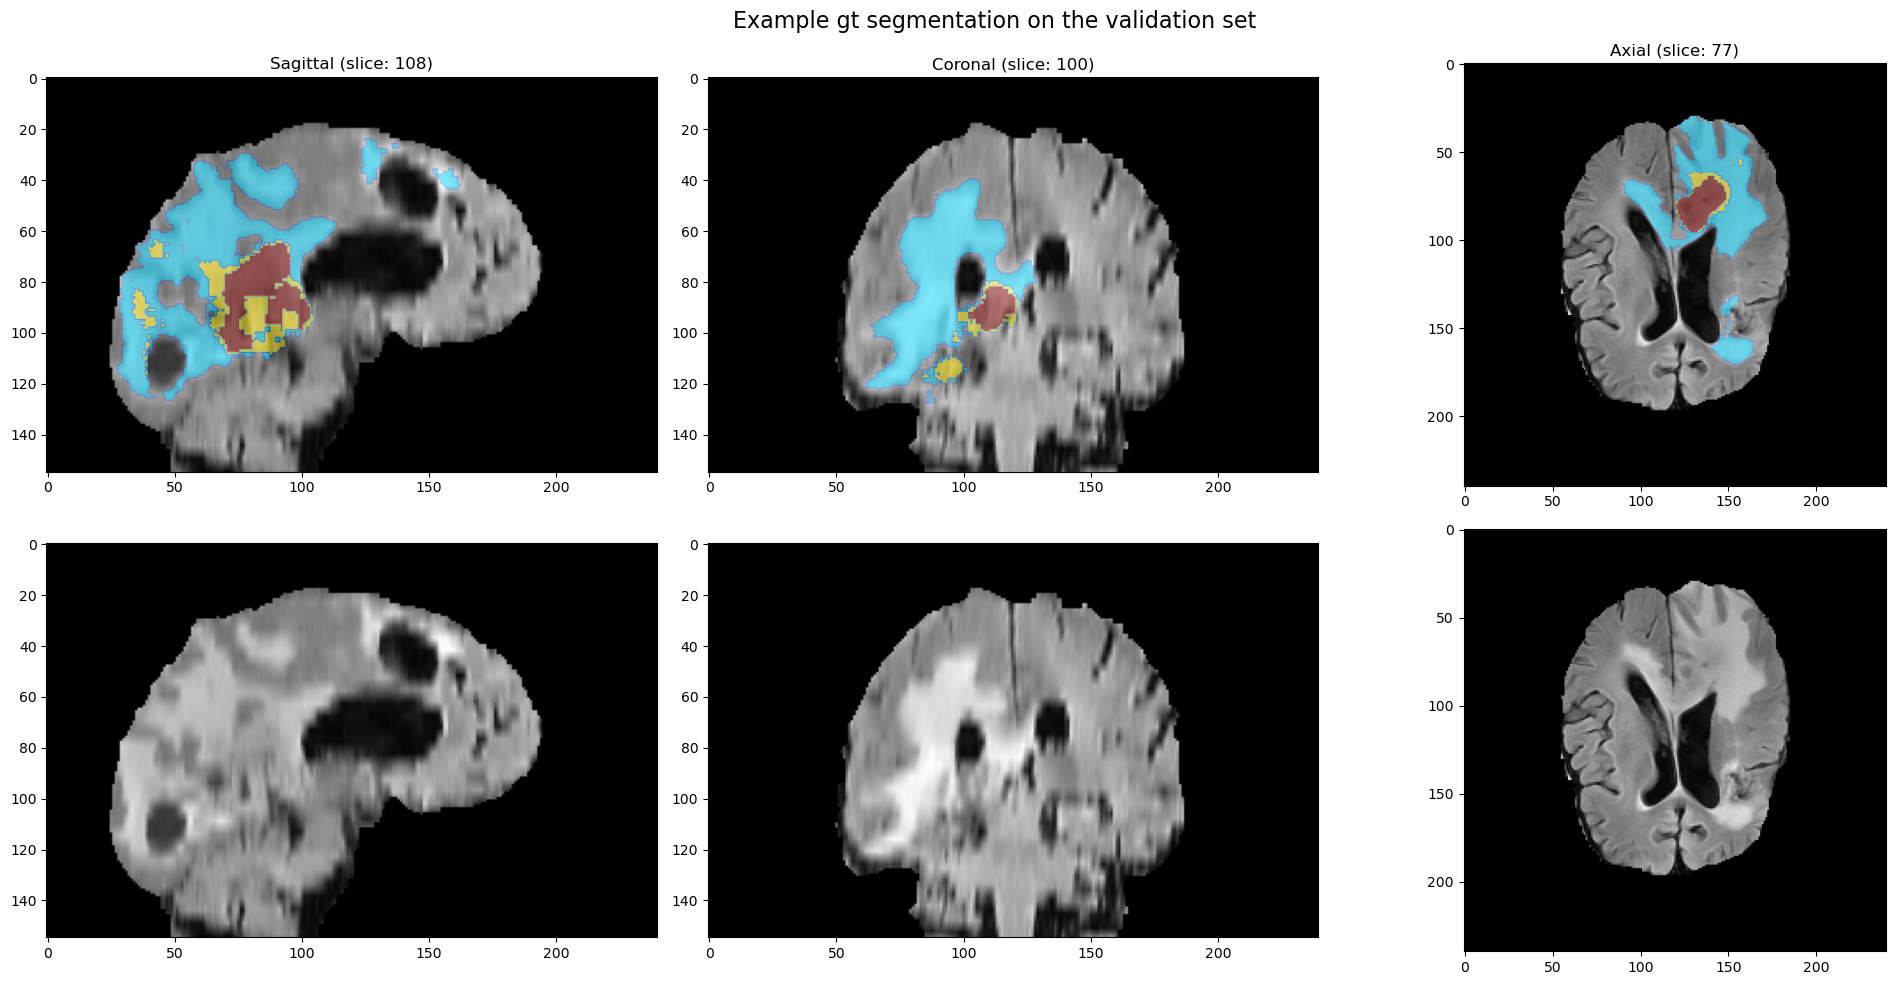

In [32]:
image = test_sample[0][0].numpy() # shape needs to be 3 (H, W, D) & converted to numpy
seg = test_sample[1][0].numpy()

plot_segmentations(image, seg, gt_seg=seg, title='Example gt segmentation on the validation set')

# Task 1: Evaluation and Visualization

**Q1a**. We first have to define how good our predicted segmentations are. Implement the evaluation functions below.

In [ ]:
# The Dice similarity coefficient is widely used for evaluating image segmentation alogrithms.
# Implement a method that computes the patient-wise Dice score, precision, and recall (mean and std) for the test dataset.
# Hint: Don't forget that there are multiple classes. The background (label=0) is not a class! 
# --------------------------- ADD YOUR CODE HERE ------------------------------
def Dice(predictions, gt):
  mean, std = None, None
  return mean, std

def precision(predictions, gt):
  mean, std = None, None
  return mean, std

def recall(predictions, gt):
  mean, std = None, None
  return mean, std

# ----------------------------------- END -------------------------------------

**Q1b**. Next, we want to visualize the best- and worst-performing samples in the test set. Implement a function that evaluates the entire test dataset and outputs the index of the best and worst performing samples according to the Dice coefficient.

Hint: Don't forget to `argmax` your predictions while visualizing :) 

In [ ]:
# You may change the functions below as you see fit

# --------------------------- ADD YOUR CODE HERE ------------------------------
def get_best_and_worst_ids(predictions):
    best_ids, worst_ids = -1, -1
    best_performance, worst_performance = None, None

    # TODO: implement

    return {
        'best_id': best_ids,
        'best_performance': best_performance,
        'worst_id': worst_ids,
        'worst_performance': worst_performance
    }

def visualize_best_and_worst_samples(predictions, test_ds):
    '''
    Use the get_best_and_worst_ids function to get the best and worst performing subjects.
    Use ground truth segmentations (get_seg) to determine which slices of the MRI scans to visualize.
    '''

    return_dict = get_best_and_worst_ids(predictions)

    best_id = return_dict['best_id']
    plot_segmentations(test_ds[best_id][0][0].numpy(), predictions[best_id], gt_seg=test_ds[best_id][1][0].numpy(), 
                       title=f'Best prediction on the test set (Dice: {return_dict["best_performance"]:.2f})')

    worst_id = return_dict['worst_id']
    plot_segmentations(test_ds[worst_id][0][0].numpy(), predictions[worst_id], gt_seg=test_ds[best_id][1][0].numpy(), 
                       title=f'Worst prediction on the test set (Dice: {return_dict["worst_performance"]:.2f})')

# ----------------------------------- END -------------------------------------

**Q1c**. Given a set of predictions for a number of models, create a summary figure of your choice (e.g. table, bar plot) which visualizes all of the metric values. Visualize multiple metrics (Dice coefficient, precision, and recall), each computed for every tissue type. A sample dictionary is provided below.

In [ ]:
# --------------------------- ADD YOUR CODE HERE ------------------------------

def get_results_dictionary(predictions):
    results_dict = None
    # TODO: implement
    return results_dict

def plot_results_summary(results_dict: Dict[str, Dict[str, Dict[str, str]]]) -> None:
    # TODO: implement
    pass
# ----------------------------------- END -------------------------------------

sample_results = {
    'baseline1': {
        'ED': {'dice': '0.7', 'precision': '0.82', 'recall': '0.6'},
        'NCT': {'dice': '0.72', 'precision': '0.86', 'recall': '0.61'},
        'ET': {'dice': '0.74', 'precision': '0.88', 'recall': '0.59'},
    },
    'baseline2': {
        'ED': {'dice': '0.6', 'precision': '0.5', 'recall': '0.7'},
        'NCT': {'dice': '0.61', 'precision': '0.46', 'recall': '0.72'},
        'ET': {'dice': '0.9', 'precision': '0.88', 'recall': '0.92'},
    }
}
plot_results_summary(sample_results)

# Task 2: Unsupervised segmentation

The first approach aims to segment the brain tissues, including edema (ED), non-enhancing tumor (NCT), enhancing tumor core (ET), and background using unsupervised classical machine learning techniques.

Different unsupervised techniques to leverage the different intensity profile of the tissues should be explored.

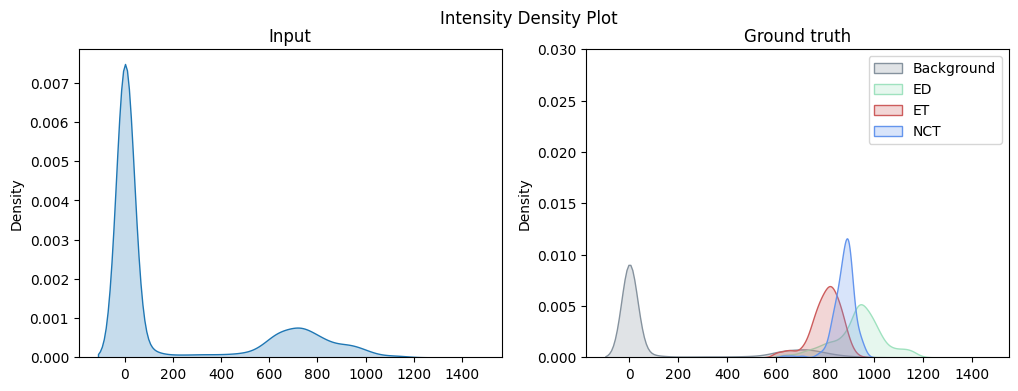

In [226]:
slice_id = 77
im_ = test_sample[0][0,...,slice_id].numpy().flatten()
seg_ = test_sample[1][0,...,slice_id].numpy().flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='ED', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='ET', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='NCT', legend=True)
axes[1].set_ylim(0, 0.03)
axes[1].set_title('Ground truth')
plt.legend()

## Unsupervised Learning

Here, you should experiment with different *classical* unsupervised machine learning methods, e.g., clustering, density estimation, etc... (at least two different methods). Hint: sklearn has implementations of unsupervised methods

**HINT**: You can predict the different classes of intensities even without any training!

**HINT**: You can evaluate every volume slice-by-slice if the whole volume does not fit in the memory. Using axial slices is more conventional.

#### QUESTION Q2a.
Implement an unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 1.

In [ ]:
# Unsupervised method 1
# --------------------------- ADD YOUR CODE HERE ------------------------------
pred_seg_1 = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns_plot_1 = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Visualize the best and worst predictions on the test set for method 1
visualize_best_and_worst_samples(pred_seg_1)

#### QUESTION Q2b.
Implement a second unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 2.

In [ ]:
# Unsupervised method 2
# --------------------------- ADD YOUR CODE HERE ------------------------------
pred_seg_2 = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns_plot_2 = None
# ----------------------------------- END -------------------------------------

In [ ]:
visualize_best_and_worst_samples(pred_seg_2)

# Task 3: Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment ED, NCT, ET, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations.

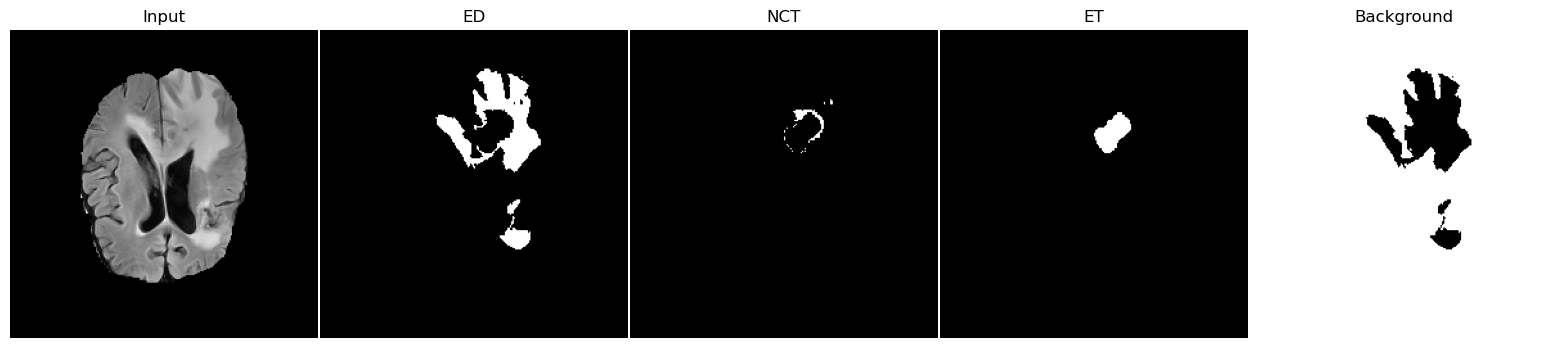

In [ ]:
def plot_labels_separately(im, seg):
    elements = [
        im, 
        (seg == 1).astype(int),
        (seg == 2).astype(int),
        (seg == 3).astype(int),
        (seg == 0).astype(int)
    ]
    titles = ['Input', 'ED', 'NCT', 'ET', 'Background']
    diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
    diffp.set_size_inches(len(elements) * 4, 4)
    for idx, ax in enumerate(axarr):
        ax.axis('off')
        ax.imshow(get_slice(elements[idx], 77, 2), cmap='gray')
        ax.set_title(titles[idx])

plot_labels_separately(test_sample[0][0].numpy(), test_sample[1][0].numpy())

## DL-based segmentation

Define and train a segmentation model of your choice (use the train, val, and test splits defined above).

Feel free to choose:
* the number of layers
* the number of features within convolutional layers
* number of convolutions within each layer
* concatenation strategy
* ...

HINT: You can use pre-defined models, e.g., from torchvision, but train them from scratch (no pre-training). 

HINT: Be careful with `output channels` of your model, and compatibility with your loss function


In [ ]:
# Define a neural network for segmentation

# --------------------------- ADD YOUR CODE HERE ------------------------------
class MySegmentationModel(torch.nn.Module):
    def __init__(self):
        super().__init__()


model = MySegmentationModel()
# ----------------------------------- END -------------------------------------

We also want to see your training loop. So, no trainer libraries (PyTorch Lightning, etc.) are allowed. 

HINT: Monitoring validation metrics is always handy

In [ ]:
# Define your trainining loop
epochs: int = None

# --------------------------- ADD YOUR CODE HERE ------------------------------
for epoch in range(epochs):
    for batch in train_loader:
        image, label = batch
        # Forward pass
        # Backward pass
        # Optimize
        pass
# ----------------------------------- END -------------------------------------

In [ ]:
pred_seg_3 = None

After training and evaluating, save your model weights and include them in your submission together with your notebook. We are going to run the test prediction with your model, so the results should be reproducible.

In [ ]:
torch.save(model.state_dict(), './mymodel_for_submission.pth') 

### Evaluate the Dice scores (separately for every tissue type) for the whole test set.

Visualize individual segmentation channels for axial slice 77 of all three approaches and the ground truth in a similar style as above

In [ ]:
# Implement

image = test_sample[0][0,...,77].numpy()
gt_seg = test_sample[1][0,...,77].numpy()

# --------------------------- ADD YOUR CODE HERE ------------------------------
plt_seg_1 = None
plt_seg_2 = None
plt_seg_3 = None
plt_gt = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Run this block after implementing Q3.
visualize_best_and_worst_samples(pred_seg_3)

### Summarize the results of all of the segmentation methods implemented.

In [ ]:
# Run this block after implementing Q1-3.
results_dictionary = {
    'unsupervised1': get_results_dictionary(pred_seg_1),
    'unsupervised2': get_results_dictionary(pred_seg_2),
    'deep learning': get_results_dictionary(pred_seg_3),
}
plot_results_summary(results_dictionary)

## Bonus

The official BraTS Glioma Segmentation challenge (source of the data) merges the tumor classes into non-mutually exclusive labels and creats a multi-label segmentation problem with the given transform:

In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 3 is the GD-enhancing tumor
    label 2 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 3)
            d[key] = torch.stack(result, axis=0).float()
        return d

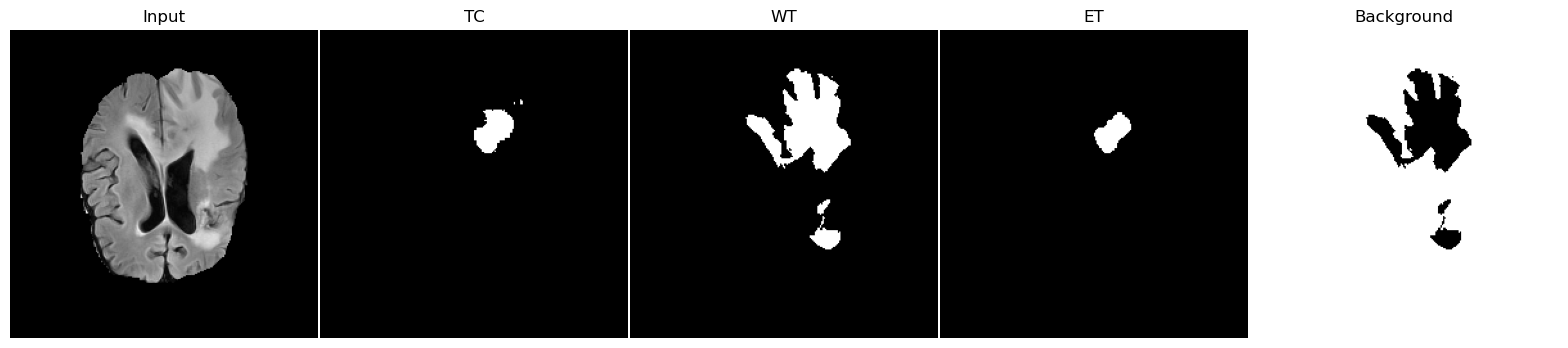

In [40]:
# Official (merged) labels look like this
def plot_merged_labels_separately(im, seg):
    tc, wt, et, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
    tc[np.logical_or(seg==2, seg==3)] = 1
    wt[np.logical_or(tc, seg==1)] = 1
    et[seg==3] = 1
    background[seg==0] = 1
    elements = [im, tc, wt, et, background]

    titles = ['Input', 'TC', 'WT', 'ET', 'Background']
    diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
    diffp.set_size_inches(len(elements) * 4, 4)
    for idx, ax in enumerate(axarr):
        ax.axis('off')
        ax.imshow(get_slice(elements[idx], 77, 2), cmap='gray')
        ax.set_title(titles[idx])

plot_merged_labels_separately(test_sample[0][0].numpy(), test_sample[1][0].numpy())

What could be the reason of this label re-mapping? Rerunning your experiments and visualizations after applying the transform can be helpful!